In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
sp500_raw = pd.read_csv('SP500.csv', index_col='Date', parse_dates=['Date'])
sp500_raw.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-23,2860.290039,2868.780029,2854.030029,2856.979980,2856.979980,2713910000
2018-08-24,2862.350098,2876.159912,2862.350098,2874.689941,2874.689941,2596190000


In [3]:
sp500 = sp500_raw.resample('BM').apply(lambda x: x[-1])
sp500.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1950-01-31,17.049999,17.049999,17.049999,17.049999,17.049999,1690000
1950-02-28,17.219999,17.219999,17.219999,17.219999,17.219999,1310000


In [4]:
sp500['Pct Change'] = sp500['Adj Close'].pct_change()
sp500.head(3)

,Open,High,Low,Close,Adj Close,Volume,Pct Change
Date,,,,,,,
1950-01-31,17.049999,17.049999,17.049999,17.049999,17.049999,1690000,NaN
1950-02-28,17.219999,17.219999,17.219999,17.219999,17.219999,1310000,0.009971
1950-03-31,17.290001,17.290001,17.290001,17.290001,17.290001,1880000,0.004065


In [82]:
def vermogensbelasting_2016(capital, gains=0):
    return max(0, 0.012 * (capital-24437))

vermogensbelasting_2016(1000000)

11706.756

In [83]:
def vermogensbelasting_2017(capital, gains=0):
    taxable = capital - 25000
    if taxable < 0:
        return 0
    
    schijf_1 = min(75000, taxable)
    schijf_2 = max(min(975000, taxable)-75000, 0)
    schijf_3 = max(taxable - 975000, 0)
    
    return (0.02871 * schijf_1 + 0.04600 * schijf_2 + 0.0539 * schijf_3) * 0.30

vermogensbelasting_2017(1000000)

13065.975

In [84]:
def vermogensbelasting_2018(capital, gains=0):
    taxable = capital - 30000
    if taxable < 0:
        return 0
    
    schijf_1 = min(70800, taxable)
    schijf_2 = max(min(978000, taxable)-70800, 0)
    schijf_3 = max(taxable - 978000, 0)
    
    return (0.02017 * schijf_1 + 0.04326 * schijf_2 + 0.0538 * schijf_3) * 0.30

vermogensbelasting_2018(100000, 0)

423.57

In [6]:
def vennootschapsbelasting(capital, gains):
    schijf_1 = min(200000, gains)
    schijf_2 = max(gains-200000, 0)
    return max(0, 0.20 * schijf_1 + 0.25 * schijf_2)

vennootschapsbelasting(0, 200000)

40000.0

In [17]:
def simulate(initial_capital, withdrawal_rate, duration_in_years=30, tax_fn=None):
    inflation = 0.02 # TODO: Use actual inflation numbers
    
    stocks_return = sp500['Pct Change'] .dropna()
    inflation_per_month = inflation / 12
    months = duration_in_years * 12
    run_index = np.arange(0, months)
    initial_data = {'capital': 0.0, 'market_return': 0.0,'withdrawal': 0.0, 'taxes': 0.0}

    samples = stocks_return.size-months-1
    results = pd.DataFrame(index=np.arange(0, samples), data={'end_value': 0.0})

    for p in results.index:
        run = pd.DataFrame(index=run_index, data=initial_data)
        run.index.name = 'month'

        capital = initial_capital
        withdrawal = withdrawal_rate / 12 * initial_capital 

        # loop over months
        for m in run.index:
            market_return = stocks_return.iloc[m+p]
            gain = capital * market_return

            # pay taxes every 12th month
            taxes = 0
            if m % 12 == 0 and tax_fn:
                taxes = tax_fn(capital, gain)

            run.at[m, 'capital'] = capital
            run.at[m, 'market_return'] = market_return
            run.at[m, 'withdrawal'] = withdrawal
            run.at[m, 'taxes'] = taxes     

             # withdraw inflation adjusted WR amount
            capital -= withdrawal

            # calculate inflation adjusted withdrawal amount
            withdrawal = withdrawal * ( 1 + inflation_per_month )

            # add capital gains
            capital += gain

            # pay taxes
            capital -= taxes

            # at the end of simulation, add to results dataframe
            if m == months-1:
                results.at[p, 'end_value'] = capital
    
    return results

res = simulate(1000000, 0.04, 30)
res.head(2)

,end_value
0,3.540353e+06
1,3.480167e+06


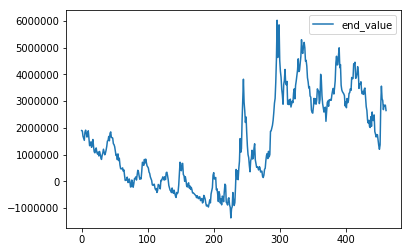

In [14]:
res.plot()

In [37]:
def success_rate(results, min_capital=0):
    return results[results['end_value'] > min_capital].size / results.size


print("End value was higher than 0 in {0:.0%} of all simulations".format(success_rate(res, min_capital=0)))
print("End value was higher than initial capital (adjusted for inflation) in {0:.0%} of all simulations".format(success_rate(res, min_capital=1000000*pow(1.02, 30))))

End value was higher than 0 in 98% of all simulations
End value was higher than initial capital (adjusted for inflation) in 61% of all simulations


In [40]:
wr = 0.04
vermogen = 1000000
results = simulate(vermogen, wr, 30, vermogensbelasting_2018)

print("Tax rules: Vermogensbelasting NL 2018")
print("Withdrawal rate was {0:.0%}".format(wr))
print("Success rate: {0:.0%}".format(success_rate(results)))
print("Median end value is: ${:.2f}".format(results['end_value'].median()))
print("Best end value is: ${:.2f}".format(results['end_value'].max()))
print("Worst end value is: ${:.2f}".format(results['end_value'].min()))


Tax rules: Vermogensbelasting NL 2018
Withdrawal rate was 4%
Success rate: 77%
Median end value is: $1093180.45
Best end value is: $6021485.72
Worst end value is: $-1365223.17


In [43]:
wr = 0.0333
vermogen = 960000
results = simulate(vermogen, wr, 30, vennootschapsbelasting)

print("Tax rules: Vennootschapsbelasting NL 2018")
print("Withdrawal rate was {0:.0%}".format(wr))
print("Success rate: {0:.0%}".format(success_rate(results)))
print("Median end value is: ${:.2f}".format(results['end_value'].median()))
print("Best end value is: ${:.2f}".format(results['end_value'].max()))
print("Worst end value is: ${:.2f}".format(results['end_value'].min()))


Tax rules: Vennootschapsbelasting NL 2018
Withdrawal rate was 3%
Success rate: 100%
Median end value is: $2795565.50
Best end value is: $8940970.51
Worst end value is: $469326.57


In [85]:
capital = 1000000 # initial capital
duration = 30 # years

sr_overview = pd.DataFrame(index=[3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.4], data={'belastingvrij': 0.0, 'vermogensbelasting 2018': 0.0, 'vennootschapsbelasting 2018': 0.0})
for wr in sr_overview.index:
    results = simulate(capital, wr/100, duration)
    sr_overview.at[wr, 'belastingvrij'] = success_rate(results) * 100
    
    results = simulate(capital, wr/100, duration, vermogensbelasting_2018)
    sr_overview.at[wr, 'vermogensbelasting 2018'] = success_rate(results) * 100
    
    results = simulate(capital, wr/100, duration, vennootschapsbelasting)
    sr_overview.at[wr, 'vennootschapsbelasting 2018'] = success_rate(results) * 100
    
    results = simulate(capital, wr/100, duration, vermogensbelasting_2017)
    sr_overview.at[wr, 'vermogensbelasting 2017'] = success_rate(results) * 100
    
    results = simulate(capital, wr/100, duration, vermogensbelasting_2016)
    sr_overview.at[wr, 'vermogensbelasting 2016'] = success_rate(results) * 100
    
sr_overview

,belastinvrij,vermogensbelasting 2018,vennootschapsbelasting 2018,belastingvrij,vermogensbelasting 2017,vermogensbelasting 2016
3.0,0.0,100.000000,100.000000,100.000000,100.000000,100.000000
3.2,0.0,100.000000,100.000000,100.000000,100.000000,100.000000
3.4,0.0,98.701299,100.000000,100.000000,97.619048,98.701299
3.6,0.0,92.857143,100.000000,100.000000,89.610390,92.857143
3.8,0.0,82.900433,98.268398,100.000000,80.086580,82.900433
4.0,0.0,77.056277,92.857143,97.619048,74.458874,77.056277
4.2,0.0,67.965368,85.930736,91.774892,66.450216,68.831169
4.4,0.0,61.688312,78.787879,84.632035,60.606061,62.121212


Text(0.5, 1.02, 'Vermogen = 1M   Duur = 30 jaar')

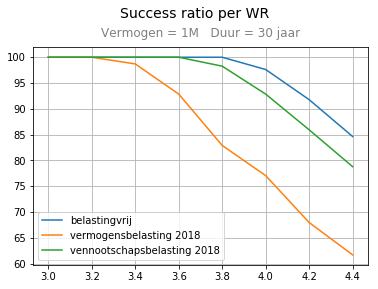

In [88]:
sr_overview[['belastingvrij', 'vermogensbelasting 2018', 'vennootschapsbelasting 2018']].plot(grid=True)
plt.suptitle("Success ratio per WR", y=1.02, fontsize=14)
plt.title("Vermogen = 1M   Duur = 30 jaar", fontsize=12, y=1.02, color='grey')

Text(0.5, 1.02, 'Vermogen = 1M   Duur = 30 jaar')

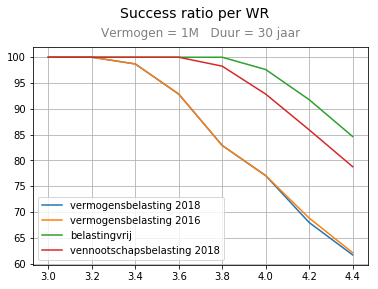

In [87]:
sr_overview[['vermogensbelasting 2018', 'vermogensbelasting 2016', 'belastingvrij', 'vennootschapsbelasting 2018']].plot(grid=True)
plt.suptitle("Success ratio per WR", y=1.02, fontsize=14)
plt.title("Vermogen = 1M   Duur = 30 jaar", fontsize=12, y=1.02, color='grey')

In [89]:
sr_overview

,belastinvrij,vermogensbelasting 2018,vennootschapsbelasting 2018,belastingvrij,vermogensbelasting 2017,vermogensbelasting 2016
3.0,0.0,100.000000,100.000000,100.000000,100.000000,100.000000
3.2,0.0,100.000000,100.000000,100.000000,100.000000,100.000000
3.4,0.0,98.701299,100.000000,100.000000,97.619048,98.701299
3.6,0.0,92.857143,100.000000,100.000000,89.610390,92.857143
3.8,0.0,82.900433,98.268398,100.000000,80.086580,82.900433
4.0,0.0,77.056277,92.857143,97.619048,74.458874,77.056277
4.2,0.0,67.965368,85.930736,91.774892,66.450216,68.831169
4.4,0.0,61.688312,78.787879,84.632035,60.606061,62.121212
